In [324]:
import os
from dotenv import load_dotenv
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit_ibm_runtime import (SamplerV2 as Sampler, EstimatorV2 as Estimator)
from qiskit.primitives import (BackendEstimatorV2, BackendSamplerV2)

## Quantum Coinflip
I am using a coinflip example to get familiar with the basics of qiskit. I only have a basic level of understanding of quantum informatics, so there are likely some inaccuracies.

To do a coinflip I want to place a single qubit in an equal superposition of $|0\rangle$ and $|1\rangle$, so that when measured there is a 50-50 probability of being in either state. The easiest way to do that is to apply a Hadamard gate to $|0\rangle$ so that $\psi = |0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1|\rangle)$.

As a side, the Hadamard gate corresponds to a $\pi$ rotation around the X+Z axis, and has the effect of changing the compuational basis so that:
   - $|0\rangle \leftrightarrow |+\rangle = \frac{1}{\sqrt(2)}(|0\rangle + |1\rangle)$.
   - $|1\rangle \leftrightarrow |-\rangle = \frac{1}{\sqrt(2)}(|0\rangle - |1\rangle)$.

Applying the Hadamard gate again changes the computational basis back. This will help visualise what is going on in the future I think. 

a  (0.7071067811865475+0j) b:  (0.7071067811865475+0j)


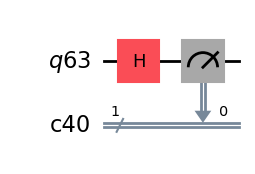

In [178]:
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
print('a ', Statevector(qc)[0], 'b: ', Statevector(qc)[1])
qc.measure(q0,c0)
qc.draw('mpl')

In [179]:
# Run a quick test of the circuit on a simulated backend.
backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, backend)
job = backend.run(qc, shots=1024)
result = job.result().get_counts()
print(result)

{'0': 534, '1': 490}


Success! If we apply the Hadamard gate again, we should, in theory, instead see every sample count as 0. As we have $|0\rangle \rightarrow |+\rangle \rightarrow |0\rangle$

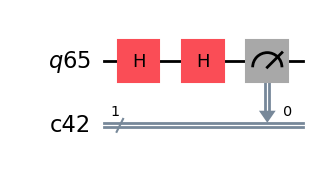

In [182]:
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
qc.h(q0)
qc.measure(q0,c0)
qc.draw('mpl')

In [181]:
qc = transpile(qc, backend)
job = backend.run(qc, shots=1024)
result = job.result().get_counts()
print(result)

{'0': 1024}


#### Sampler on the IBM Backend
Now I want to run this basic single Hadamard gate circuit on real hardware. Following the instructions on qiskit's documentation make this relatively painless.
 - Connect to IBM's quantum service using my API, and instance CRN.
  - Pick backend hardware to use, ideally the least busy open quantum computer.
  - Reframe circuit so that it can be used by the backend.
  - Run circuit on backend.

In [185]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

# Connect to my runtime service.
service = QiskitRuntimeService(token=API_TOKEN,instance=CRN)

# Use the least busy backend
backend = service.least_busy()
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)

qiskit_runtime_service._discover_account:WARNING:2025-11-05 18:06:03,118: Loading account with the given token. A saved account will not be used.


Name: ibm_fez
Version: 2
No. of qubits: 156



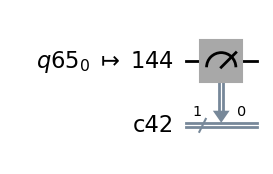

In [186]:
# Transpile circuit into something interpretable by the chosen quantum backend
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3) # this is the transpiler
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

Above is the transposition of the circuit. A phase rotation of $\pi/2$, followed by a single qubit Sqrt(X) gate, and another $\pi/2$ rotation. The Sqrt(X) gate is a half-NOT gate - if I applied this twice I would get the single NOT gate. So the Sqrt(X) rotates the qubit $\pi/2$ around the x-axis, much like half flipping a coin so that it stands on it's side. I think this makes some sense when thinking about the corresponding movement on the Bloch sphere, and as the Hadamard gate as a rotation about the X+Z axis but would like to study it further.

Below is the execution of the circuit on the backend chosen above. There seem to be two ways of executing a quantum circuit on hardware, being the Sampler and Estimator primitives. My understanding is that primitives are a high-abstraction interface that allow us to run Quantum Computing tasks without getting bogged down in the nitty gritty of error correction, backend parameters etc.

The Sampler primitive runs the circuit and samples the classical registers. My main goal at the moment is to simply count the number of times the circuit returns $|0\rangle$, and $|1\rangle$, so this seems appropriate. 

In [65]:
# ## Run sample 1000 times on hardware
# sampler = Sampler(mode=backend)
# pubs = [qc_isa]
# job = sampler.run(pubs, shots=1000)
# res = job.result()

To save computation time on the service, I can fetch the results instead of waiting in a queue again.

In [66]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45c4bd63mfc73a6rqs0')
job_result = job.result()

qiskit_runtime_service._discover_account:WARNING:2025-11-05 14:51:52,245: Loading account with the given token. A saved account will not be used.


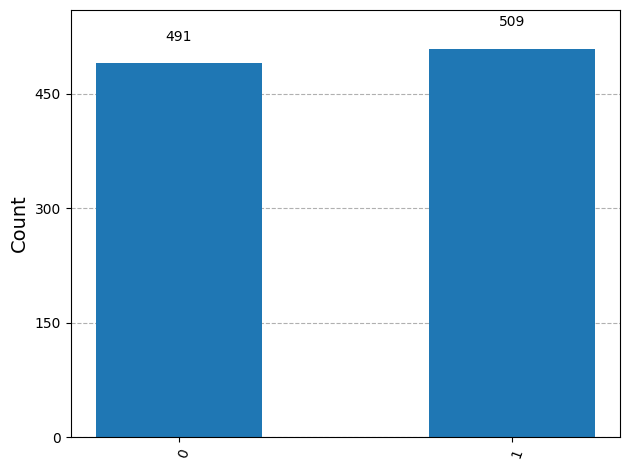

In [67]:
# Plot histogram of resulting states.
pub_result = job_result[0].data.c1.get_counts()
plot_histogram(pub_result)

Looks a somewhat even split. Seems to be random up to some statistical fluctuation. But what if we use an estimator to look at the results instead?

#### Estimator
An estimator calculates the expected value of an observable with respect to a quantum state. We measure in the Z-basis, so it seems natural to try an estimate in that basis also. I.e. the expected value of the Pauli $Z$ matrix. We have that:

$E(Z) = \langle \psi | Z | \psi \rangle = \frac{1}{2} \langle 0 | Z | 0 \rangle + \frac{1}{2} \langle 1 | Z | 1 \rangle = \frac{1}{2}(+1) + \frac{1}{2}(-1) = 0$.

In other words, we estimate an expected value of 0.

In [187]:
# Create coinflip circuit. No measuring needed.
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)

# Transpile
obs = Pauli('Z')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

In [188]:
print('Simulated E[Z] = ', res[0].data.evs)

Simulated E[Z] =  -0.01611328125


In [198]:
## Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [193]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45p8l6n7jjs73bst07g')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-05 18:18:33,099: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: -0.000493339911198816


Great! This was the expected result: the coinflip is expected to be 50-50 when estimating in the Z-basis.

What about estimating in other basis. Since the Hadamard gate is a rotation around the X+Z axis, I want to try estimating in the X axis. For this I will use the Pauli X (NOT) gate. On the IBM qiskit learning site, they describe this as estimating 'heads left or right' rather than 'heads up or down'. The NOT gate applied to the new computational basis states gives

 - $X|+\rangle = |+\rangle \implies \langle+|X|+\rangle = \langle+||+\rangle = +1$
 - $X|-\rangle = -|-\rangle \implies \langle-|X|-\rangle = -\langle-||-\rangle = -1$

If $\psi$ was equally placed between these states I would expect a value of 0. However, the coinflip circuit applies a Hadamard gate to $|0\rangle$ yielding $|+\rangle$, so instead I expect a value of +1.

In [194]:
# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

Simulated E[X] =  0.9892578125


In [195]:
# # Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [197]:
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45rj7ejf4ms73ap36kg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-05 20:57:09,634: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: 1.0


We get an expected value of +1. I think this is because of the phase of the qubit. If I rotate by $\pi/2$ around the Z-axis, it should superposition to between $|+\rangle$ and $|-\rangle$. Let's see.

In [206]:
# Create new coinflip circuit
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)
qc_e.p(np.pi/2, q_e)

# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

print('Simulated E[X] = ', res[0].data.evs)

Simulated E[X] =  -0.017578125


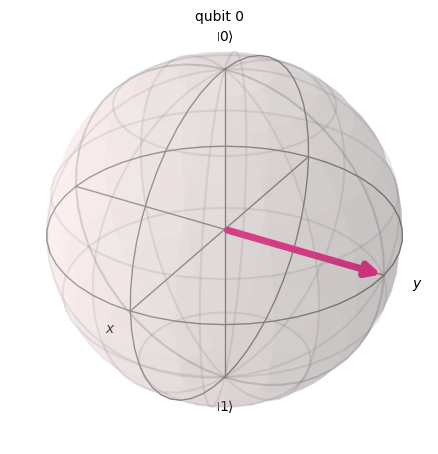

In [209]:
Statevector(qc_e).draw('bloch')

Looking at the Bloch Sphere, we can see that with the phase rotation the qubit is now 'balanced' in the x-axis and the z-axis, though not the y-axis.
#### Weighted Coinflip
For example, I want to manipulate the amplitudes by rotating the qubit so that when measuring in the z-basis I have a 75:25 split.

This looks like $|\psi\rangle = 0.75 |0\rangle + 0.25 |1\rangle$. From the trig on the bloch spehere $|\psi\rangle = cos \frac{\theta}{2} |0\rangle + e^{i\phi} sin \frac{\theta}{2} |1\rangle$.

 - $cos \theta/2 = \sqrt{3}/2$
 - $sin \theta/2 = 1/2$

Therefore $\theta = \pi/3$. If we implement this between Hadamard gates we should achieve the desired rotation around the y-axis. 

In [316]:
# Create new coinflip circuit
q = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(q, cr)
qc.h(q)
qc.ry(np.pi/3, q)
qc.h(q)
qc.measure_all()

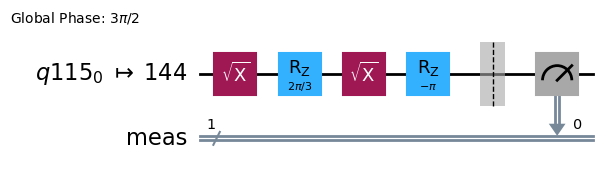

In [317]:
# Transpile
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

In [319]:
backend_sim = AerSimulator.from_backend(backend)
sampler_sim = BackendSamplerV2(backend=backend_sim)
job = sampler_sim.run([[qc_isa]], shots = 1000)
res = job.result()
# counts=job.result()[0].data.meas.get_counts()

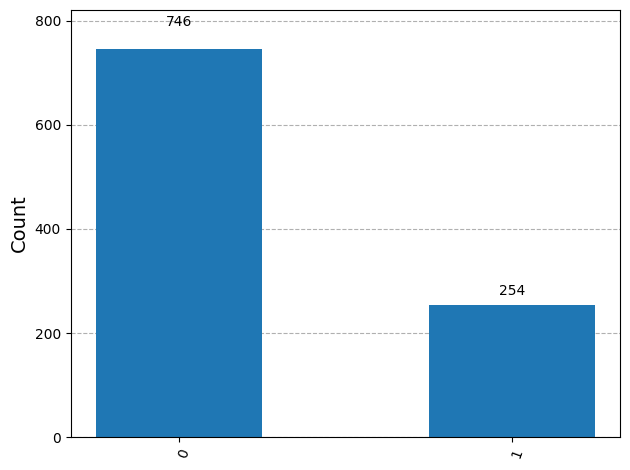

In [323]:
plot_histogram(res[0].data.meas.get_counts())